In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch
import random


## Building a Color-Biased Dataset

To analyze neuron behavior under bias, we train a CNN on a dataset where each digit is strongly correlated with a specific color.  
This encourages the model to learn both **shape features** and **color shortcuts**, which we later probe using neuron visualization.


In [ ]:


digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.2, 0.7, 0.7]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}
swapped_colors = {i: digit_colors[(i + 1) % 10] for i in range(10)}
class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95,is_hard=False):
        self.bias_prob = bias_prob
        self.is_hard_set = is_hard

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask
        if self.is_hard_set:
            if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color =  digit_colors[label]
            else:
              base_color = swapped_colors[label]
        else:
          # Choose dominant or random color
          if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color = digit_colors[label]
          else:
              base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = foreground = 0.8 * fg_color + 0.2 * grayscale.repeat(3,1,1) + fg_texture


        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.3 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [ ]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob,is_hard=False):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob,is_hard=is_hard)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [ ]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95,is_hard=False)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.05,is_hard=True)  # mostly wrong colors


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]


In [ ]:
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 2,3)
        self.conv2 = nn.Conv2d(16, 24, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(24*2*2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [ ]:
import torch
from google.colab import files
import io

def load_model_weights(model, device):
    uploaded = files.upload()
    if uploaded:
        filename = next(iter(uploaded))
        state_dict = torch.load(io.BytesIO(uploaded[filename]), map_location=device)
        model.load_state_dict(state_dict)
        print(f"Weights loaded from {filename}")
    else:
        print("No file uploaded.")


# upload the weights of the models of Task1_v4.pth given in github under folder /Task2/weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)  # Replace 'Net' with your model class if named differently
load_model_weights(model, device)



Saving Task1_v4.pth to Task1_v4.pth
Weights loaded from Task1_v4.pth


## Neuron Activation via Gradient Ascent

We start from random noise and iteratively update the image so that a chosen neuron’s activation increases.  
This reveals the **preferred visual pattern** for that neuron.


Step 0, Loss: 2.8792
Step 10, Loss: -22.4028
Step 20, Loss: -45.0017
Step 30, Loss: -68.4597
Step 40, Loss: -92.9421
Step 50, Loss: -118.0605
Step 60, Loss: -143.3888
Step 70, Loss: -168.7812
Step 80, Loss: -194.1754
Step 90, Loss: -219.6174


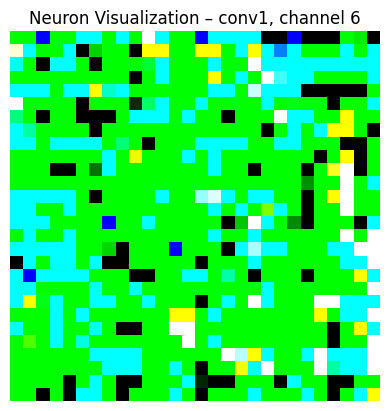

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

target_layer = model.conv2
channel_id = 6

activations = None
def hook_fn(module, input, output):
    global activations
    activations = output

hook = target_layer.register_forward_hook(hook_fn)

input_img = torch.randn(1, 3, 28, 28, requires_grad=True, device=device)
optimizer = torch.optim.Adam([input_img], lr=0.1)

steps = 100
for step in range(steps):
    optimizer.zero_grad()
    model(input_img)
    act = activations[0, channel_id]
    loss = -act.mean()
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

hook.remove()

img_np = input_img.detach().cpu().squeeze().permute(1, 2, 0).clamp(0, 1).numpy()
plt.imshow(img_np)
plt.title(f"Neuron Visualization – conv1, channel {channel_id}")
plt.axis("off")
plt.show()


## Visualizing for all channels in both convolutions

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_conv_neurons(model, layer, num_channels=16, steps=100, lr=0.1, device="cuda"):
    model.eval()
    imgs = []

    # Hook to capture activations
    activations = {}

    def hook_fn(module, input, output):
        activations['value'] = output

    handle = layer.register_forward_hook(hook_fn)

    for channel_id in range(num_channels):
        input_img = torch.randn(1, 3, 28, 28, requires_grad=True, device=device)
        optimizer = torch.optim.Adam([input_img], lr=lr)

        for step in range(steps):
            optimizer.zero_grad()
            model(input_img)
            act = activations['value'][0, channel_id]
            loss = -act.mean()
            loss.backward()
            optimizer.step()

        img_np = input_img.detach().cpu().squeeze().permute(1, 2, 0).clamp(0, 1).numpy()
        imgs.append(img_np)

    handle.remove()

    # Plotting
    cols = 5
    rows = (num_channels + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flat):
        if i < len(imgs):
            ax.imshow(imgs[i])
            ax.set_title(f"Channel {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


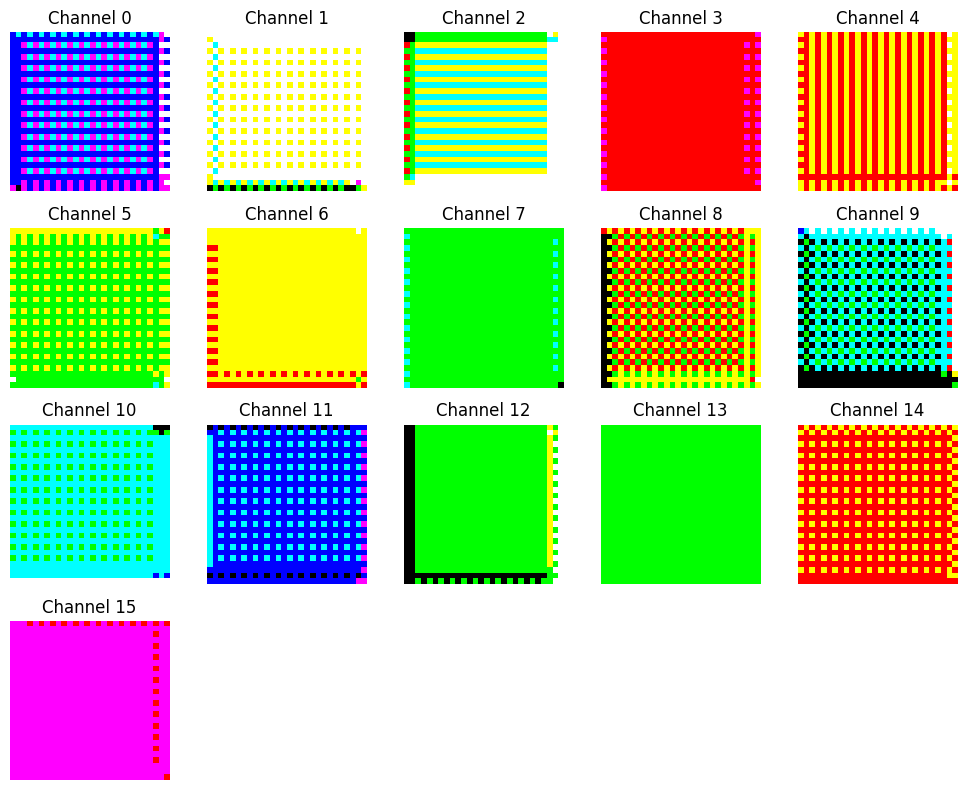

In [ ]:
visualize_conv_neurons(model, model.conv1, num_channels=16, device=device)


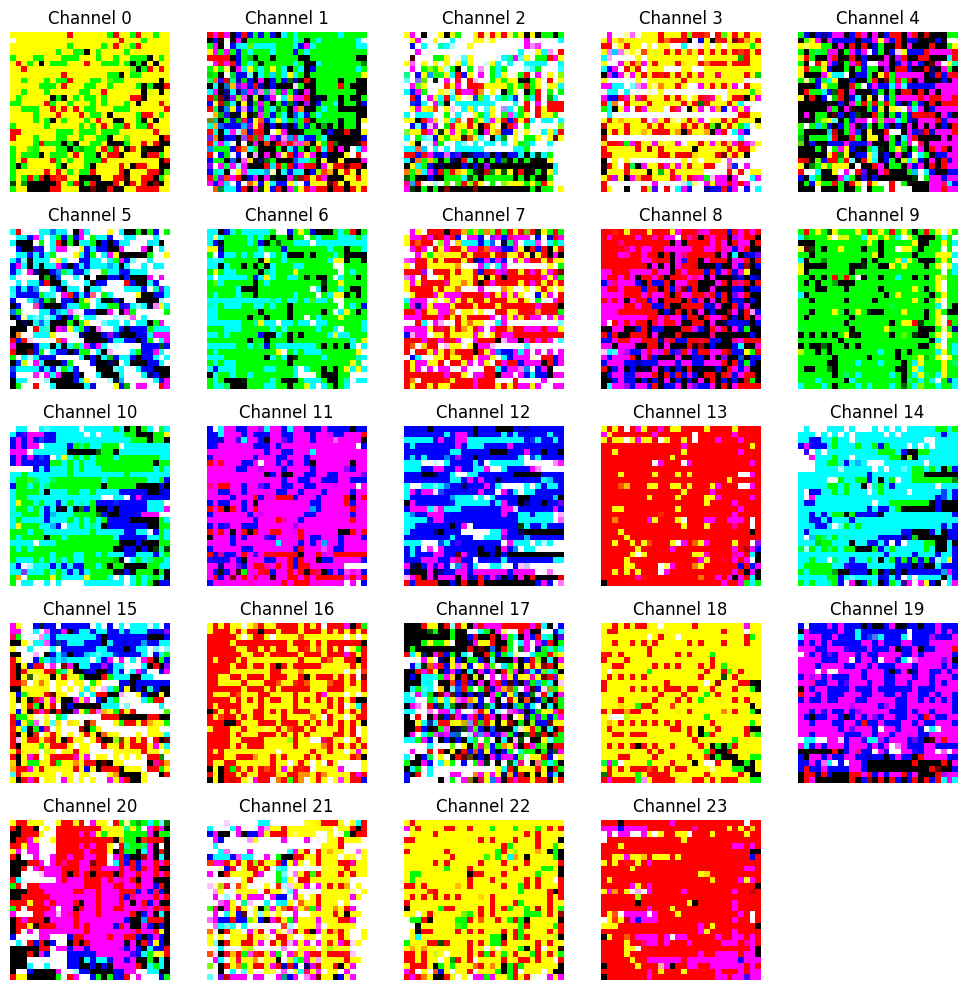

In [ ]:
visualize_conv_neurons(model, model.conv2, num_channels=24, device=device)


In [ ]:
# Remove ALL hooks from the model (safety reset)
for module in model.modules():
    module._forward_hooks.clear()
    module._backward_hooks.clear()


## Raw Spatial Neuron Visualization

Instead of averaging over a channel, we directly maximize a single spatial neuron (channel, h, w).  
This reveals very localized feature detectors such as corners, edges, or stroke intersections.


In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

model.eval()

num_channels = model.conv1.out_channels
all_scores = [[] for _ in range(num_channels)]
all_images = [[] for _ in range(num_channels)]

# Hook
def hook_fn(module, input, output):
    # output: [B, C, H, W]
    acts = output.detach().cpu()
    B, C, _, _ = acts.shape
    for b in range(B):
        for ch in range(C):
            score = acts[b, ch].mean().item()
            all_scores[ch].append(score)
            all_images[ch].append(current_batch[b])

handle = model.conv1.register_forward_hook(hook_fn)

# Forward through dataset
with torch.no_grad():
    for imgs, _ in DataLoader(train_easy, batch_size=32):
        current_batch = imgs.cpu()
        model(imgs.to(device))

handle.remove()


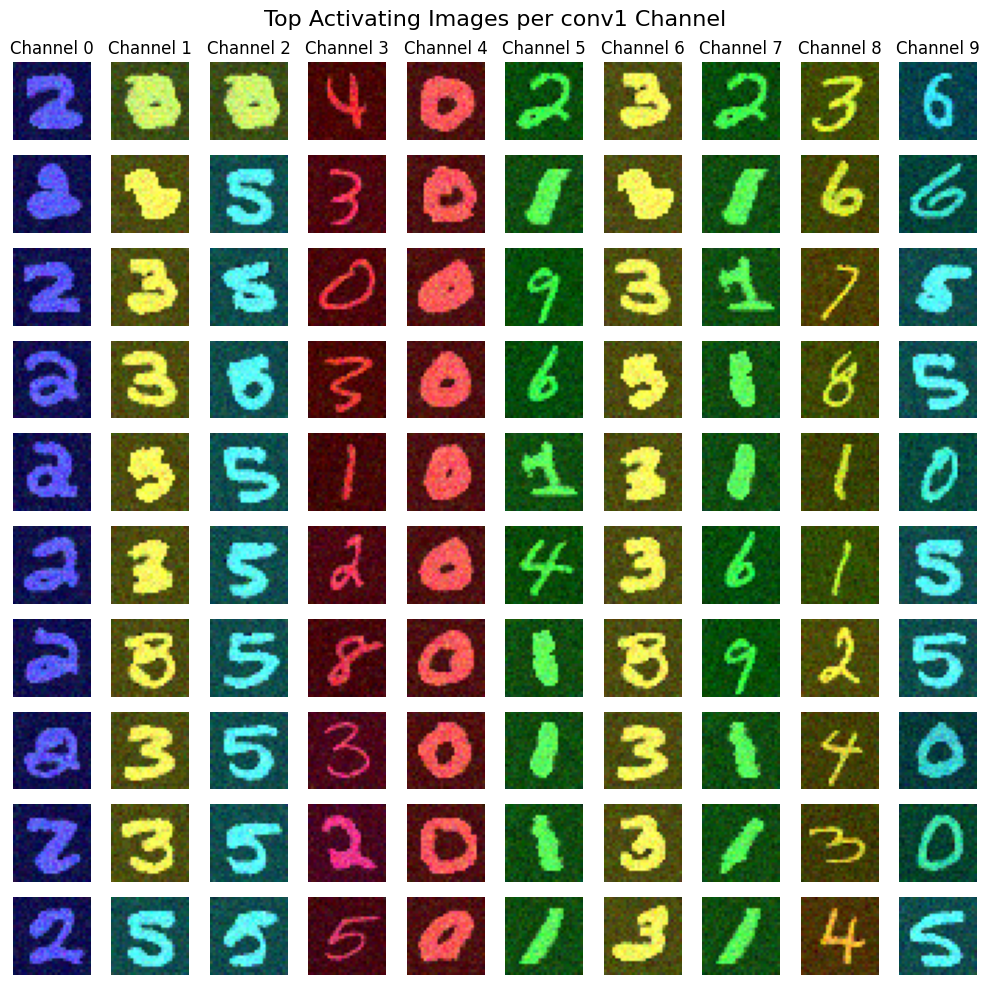

In [ ]:
top_k = 10
channels_to_show = 10

fig, axes = plt.subplots(top_k, channels_to_show, figsize=(10, 10))
fig.suptitle("Top Activating Images per conv1 Channel", fontsize=16)

for ch in range(channels_to_show):
    scores = torch.tensor(all_scores[ch])
    top_idxs = scores.topk(top_k).indices

    for i, idx in enumerate(top_idxs):
        img = all_images[ch][idx].permute(1, 2, 0).numpy()
        axes[i, ch].imshow(img)
        axes[i, ch].axis('off')
        if i == 0:
            axes[i, ch].set_title(f'Channel {ch}')

plt.tight_layout()
plt.show()


## the conv1 top activations seem to be overly concentrating on colour only

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

model.eval()

num_channels = model.conv2.out_channels
all_scores = [[] for _ in range(num_channels)]
all_images = [[] for _ in range(num_channels)]

# Hook for conv2
def hook_fn(module, input, output):
    acts = output.detach().cpu()  # [B, C, H, W]
    B, C, _, _ = acts.shape
    for b in range(B):
        for ch in range(C):
            score = acts[b, ch].mean().item()
            all_scores[ch].append(score)
            all_images[ch].append(current_batch[b])

handle = model.conv2.register_forward_hook(hook_fn)

# Forward through dataset
with torch.no_grad():
    for imgs, _ in DataLoader(train_easy, batch_size=32):
        current_batch = imgs.cpu()
        model(imgs.to(device))

handle.remove()


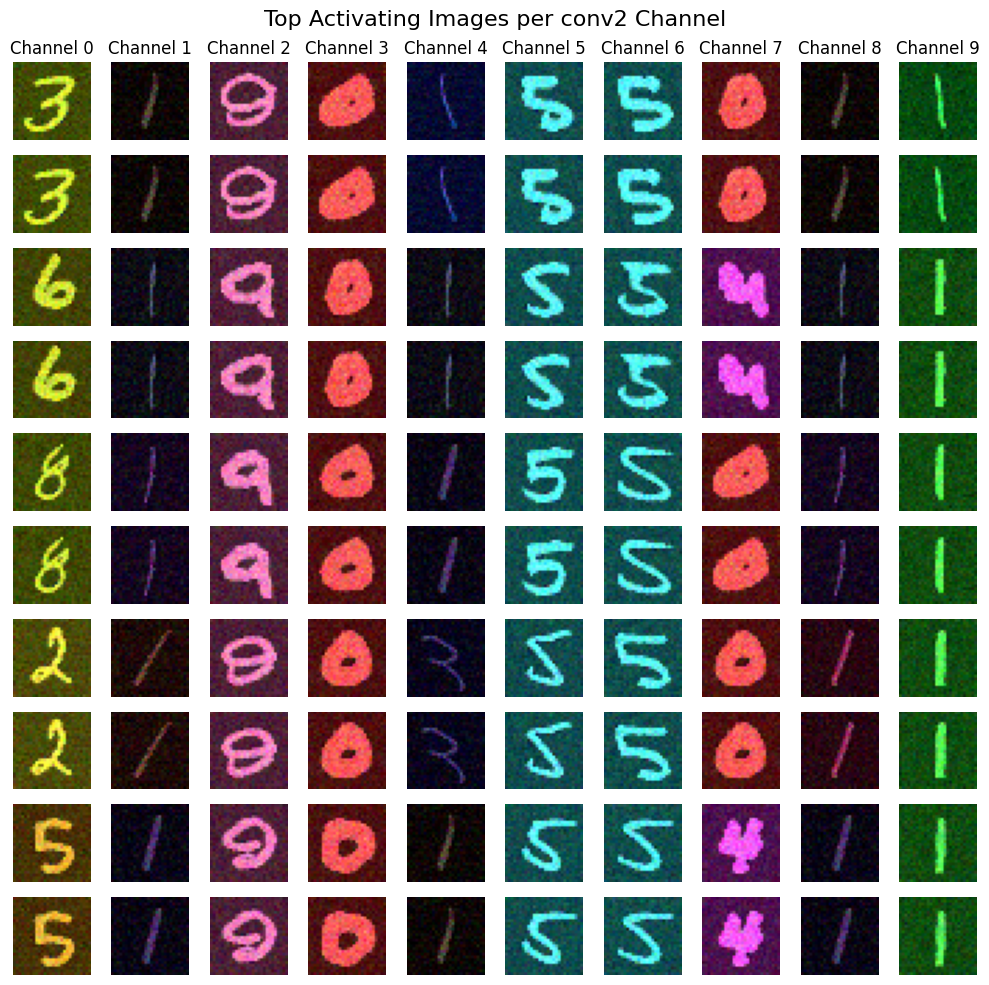

In [ ]:
top_k = 10
channels_to_show = 10

fig, axes = plt.subplots(top_k, channels_to_show, figsize=(10, 10))
fig.suptitle("Top Activating Images per conv2 Channel", fontsize=16)

for ch in range(channels_to_show):
    scores = torch.tensor(all_scores[ch])
    top_idxs = scores.topk(top_k).indices

    for i, idx in enumerate(top_idxs):
        img = all_images[ch][idx].permute(1, 2, 0).numpy()
        axes[i, ch].imshow(img)
        axes[i, ch].axis('off')
        if i == 0:
            axes[i, ch].set_title(f'Channel {ch}')

plt.tight_layout()
plt.show()


## over here we can see the channel 0 of conv2 being polysemantic and channels 1,4 and 8 classifying a stroke in the middle (1) without biasing on colour

In [ ]:
layer = model.conv2


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_raw_neuron(model, layer, channel, h, w, steps=80, lr=0.1, device="cpu"):
    model.eval().to(device)

    activations = {}

    def hook_fn(module, inp, out):
        activations["value"] = out

    handle = layer.register_forward_hook(hook_fn)

    img = torch.randn(1, 3, 28, 28, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([img], lr=lr)

    for _ in range(steps):
        optimizer.zero_grad()
        model(img)
        act = activations["value"][0, channel, h, w]
        loss = -act
        loss.backward()
        optimizer.step()
        img.data.clamp_(0, 1)

    handle.remove()

    result = img.detach().cpu().squeeze().permute(1,2,0).numpy()
    plt.imshow(result)
    plt.title(f"Raw Neuron Activation (Ch {channel}, {h},{w})")
    plt.axis("off")
    plt.show()


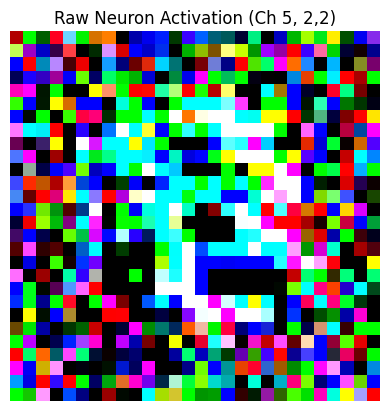

In [ ]:
visualize_raw_neuron(model, model.conv2, channel=5, h=2, w=2, device=device)


In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def top_raw_neuron_images(model, layer, dataset, channel, h, w, top_k=10, batch_size=64, device="cpu"):
    model.eval().to(device)

    scores = []
    images = []

    activations = {}

    def hook_fn(module, inp, out):
        activations["value"] = out.detach()

    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        for imgs, _ in DataLoader(dataset, batch_size=batch_size):
            imgs = imgs.to(device)
            model(imgs)
            acts = activations["value"]  # [B, C, H, W]

            neuron_scores = acts[:, channel, h, w].cpu()  # activation of that exact neuron
            scores.append(neuron_scores)
            images.append(imgs.cpu())

    handle.remove()

    scores = torch.cat(scores)
    images = torch.cat(images)

    top_vals, top_idxs = torch.topk(scores, top_k)

    print(f"Top {top_k} activations for neuron (ch={channel}, h={h}, w={w})")

    fig, axes = plt.subplots(1, top_k, figsize=(2*top_k, 2))
    for i, ax in enumerate(axes):
        img = images[top_idxs[i]].permute(1,2,0)
        ax.imshow(img)
        ax.set_title(f"{top_vals[i]:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Clear ALL hooks from model (safe reset)
for module in model.modules():
    module._forward_hooks.clear()
    module._backward_hooks.clear()


Top 10 activations for neuron (ch=5, h=2, w=2)


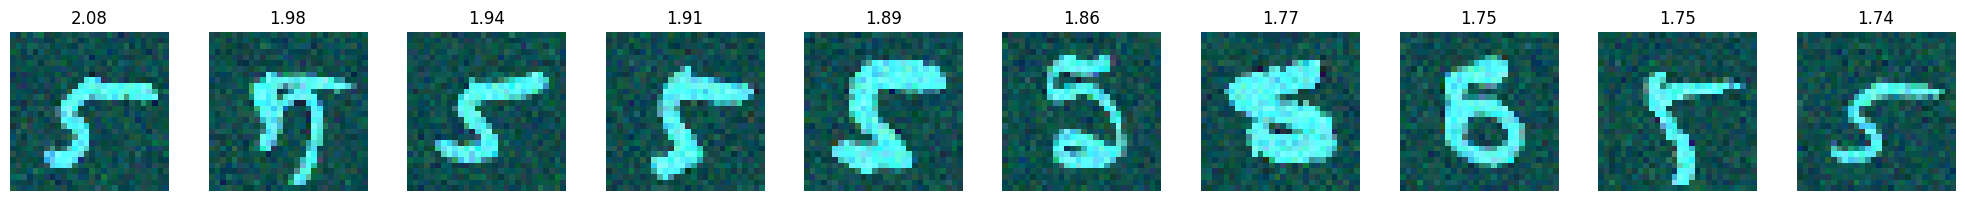

In [ ]:
top_raw_neuron_images(
    model=model,
    layer=model.conv2,
    dataset=train_easy,
    channel=5,
    h=2,
    w=2,
    top_k=10,
    device=device
)


## as we can see here this neuron(channel 5 ,(2,2)) clearly is seeing specifically for turquoise 5 as also deciphered from the optimized tensor

In [ ]:
a

## Spatial Location Sensitivity

We maximize activation at a fixed spatial location averaged across channels.  
This helps us understand what types of visual structures the network expects at different regions of the image.


In [ ]:
def visualize_spatial_location(model, layer, h, w, steps=80, lr=0.1, device="cpu"):
    model.eval().to(device)

    activations = {}

    def hook_fn(module, inp, out):
        activations["value"] = out

    handle = layer.register_forward_hook(hook_fn)

    img = torch.randn(1, 3, 28, 28, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([img], lr=lr)

    for _ in range(steps):
        optimizer.zero_grad()
        model(img)
        act = activations["value"][0, :, h, w].mean()
        loss = -act
        loss.backward()
        optimizer.step()
        img.data.clamp_(0, 1)

    handle.remove()

    result = img.detach().cpu().squeeze().permute(1,2,0).numpy()
    plt.imshow(result)
    plt.title(f"Spatial Activation Mean at ({h},{w})")
    plt.axis("off")
    plt.show()


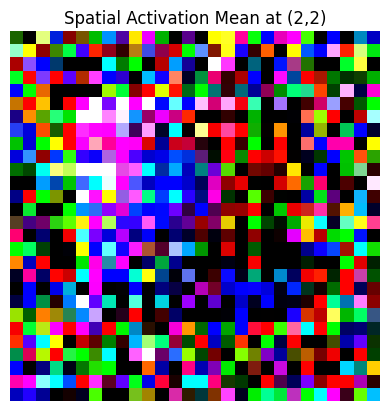

In [ ]:
visualize_spatial_location(model, model.conv2, h=2, w=2, device=device)
